# https://www.kaggle.com/c/santander-customer-satisfaction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('train_santander.csv')
print('cust_df shape:', cust_df.shape)
cust_df.head(3)

cust_df shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [2]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [7]:
print(cust_df['TARGET'].value_counts())
unsatic_count = cust_df[cust_df['TARGET']==1]['TARGET'].count()
total_count = cust_df['TARGET'].count()
print('평균 불만족:', np.round((unsatic_count/total_count), 3))

0    73012
1     3008
Name: TARGET, dtype: int64
평균 불만족: 0.04


In [11]:
cust_df.describe()
print(cust_df['var3'].value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [24]:
#cust_df.drop('ID', axis=1, inplace=True)
cust_df['var3'].replace(-999999, 2, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print(y_labels)
print('피처 데이터 shape:{0}'.format(X_features.shape))

0        0
1        0
2        0
3        0
4        0
        ..
76015    0
76016    0
76017    0
76018    0
76019    0
Name: TARGET, Length: 76020, dtype: int64
피처 데이터 shape:(76020, 369)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 {0}, 테스트 세트 {1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 갑 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 (60816, 369), 테스트 세트 (15204, 369)
학습 세트 레이블 갑 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_test, y_test), (X_train,y_train)])
auc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC:{0:.4f}'.format(auc_score))

[0]	validation_0-auc:0.803548	validation_1-auc:0.799928
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.805222	validation_1-auc:0.802222
[2]	validation_0-auc:0.813162	validation_1-auc:0.80819
[3]	validation_0-auc:0.813243	validation_1-auc:0.8127
[4]	validation_0-auc:0.816979	validation_1-auc:0.81648
[5]	validation_0-auc:0.816629	validation_1-auc:0.816018
[6]	validation_0-auc:0.817776	validation_1-auc:0.816474


KeyboardInterrupt: 

In [49]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier()
params = {
    'max_depth':[5, 7],
    'min_child_weight':[1, 3],
    'colsample_bytree':[0.5, 0.75] 
}

grid_xgb = GridSearchCV(xgb_clf, param_grid=params)
grid_xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_test, y_test), (X_train,y_train)])
print('최고의 파라미터:', grid_xgb.best_params_)

xgb_roc_score = roc_auc_score(y_test, grid_xgb.predict_proba(X_test)[:, 1])
print('auc_roc_score:{0:.4f}'.format(xgb_roc_score))

C:\Users\SYeong\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0]	validation_0-auc:0.722463	validation_1-auc:0.715421
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.807919	validation_1-auc:0.802656
[2]	validation_0-auc:0.804948	validation_1-auc:0.80013
[3]	validation_0-auc:0.809844	validation_1-auc:0.805843
[4]	validation_0-auc:0.817554	validation_1-auc:0.814728
[5]	validation_0-auc:0.812919	validation_1-auc:0.80989
[6]	validation_0-auc:0.813688	validation_1-auc:0.80994
[7]	validation_0-auc:0.820487	validation_1-auc:0.818246
[8]	validation_0-auc:0.823214	validation_1-auc:0.821681
[9]	validation_0-auc:0.821108	validation_1-auc:0.819933
[10]	validation_0-auc:0.825134	validation_1-auc:0.825898
[11]	validation_0-auc:0.827521	validation_1-auc:0.829776
[12]	validation_0-auc:0.828878	validation_1-auc:0.832087
[13]	validation_0-auc:0.827989	validation_1-auc:0.83185
[14]	validation_0-auc:0.826429	validation_1-auc:0.830253
[

[40]	validation_0-auc:0.840589	validation_1-auc:0.856429
[41]	validation_0-auc:0.840587	validation_1-auc:0.856511
[42]	validation_0-auc:0.841372	validation_1-auc:0.857765
[43]	validation_0-auc:0.841239	validation_1-auc:0.857773
[44]	validation_0-auc:0.841734	validation_1-auc:0.859167
[45]	validation_0-auc:0.841431	validation_1-auc:0.859191
[46]	validation_0-auc:0.842244	validation_1-auc:0.860261
[47]	validation_0-auc:0.842936	validation_1-auc:0.861032
[48]	validation_0-auc:0.842616	validation_1-auc:0.861347
[49]	validation_0-auc:0.842761	validation_1-auc:0.861843
[50]	validation_0-auc:0.842776	validation_1-auc:0.86211
[51]	validation_0-auc:0.843216	validation_1-auc:0.863213
[52]	validation_0-auc:0.844009	validation_1-auc:0.863963
[53]	validation_0-auc:0.844648	validation_1-auc:0.864482
[54]	validation_0-auc:0.844937	validation_1-auc:0.865133
[55]	validation_0-auc:0.844709	validation_1-auc:0.865492
[56]	validation_0-auc:0.844996	validation_1-auc:0.865993
[57]	validation_0-auc:0.845129	v

[82]	validation_0-auc:0.843864	validation_1-auc:0.871848
[83]	validation_0-auc:0.843736	validation_1-auc:0.872375
[84]	validation_0-auc:0.843938	validation_1-auc:0.872854
[85]	validation_0-auc:0.843937	validation_1-auc:0.873012
[86]	validation_0-auc:0.843777	validation_1-auc:0.873159
[87]	validation_0-auc:0.843784	validation_1-auc:0.873342
[88]	validation_0-auc:0.84379	validation_1-auc:0.873404
[89]	validation_0-auc:0.843719	validation_1-auc:0.873547
[90]	validation_0-auc:0.843773	validation_1-auc:0.873794
[91]	validation_0-auc:0.843748	validation_1-auc:0.873861
[92]	validation_0-auc:0.843632	validation_1-auc:0.873957
[93]	validation_0-auc:0.843544	validation_1-auc:0.874168
[94]	validation_0-auc:0.843575	validation_1-auc:0.874434
[95]	validation_0-auc:0.843676	validation_1-auc:0.874601
[96]	validation_0-auc:0.843733	validation_1-auc:0.874667
[97]	validation_0-auc:0.843787	validation_1-auc:0.874765
[98]	validation_0-auc:0.843801	validation_1-auc:0.874889
[99]	validation_0-auc:0.843828	v

[22]	validation_0-auc:0.835539	validation_1-auc:0.841968
[23]	validation_0-auc:0.83687	validation_1-auc:0.843748
[24]	validation_0-auc:0.838723	validation_1-auc:0.844952
[25]	validation_0-auc:0.83767	validation_1-auc:0.844679
[26]	validation_0-auc:0.837147	validation_1-auc:0.844359
[27]	validation_0-auc:0.838411	validation_1-auc:0.845869
[28]	validation_0-auc:0.839155	validation_1-auc:0.847594
[29]	validation_0-auc:0.839353	validation_1-auc:0.847181
[30]	validation_0-auc:0.839866	validation_1-auc:0.848175
[31]	validation_0-auc:0.840654	validation_1-auc:0.84937
[32]	validation_0-auc:0.840436	validation_1-auc:0.85055
[33]	validation_0-auc:0.840212	validation_1-auc:0.85021
[34]	validation_0-auc:0.839865	validation_1-auc:0.850325
[35]	validation_0-auc:0.840582	validation_1-auc:0.852574
[36]	validation_0-auc:0.840916	validation_1-auc:0.854312
[37]	validation_0-auc:0.841471	validation_1-auc:0.854618
[38]	validation_0-auc:0.841293	validation_1-auc:0.854714
[39]	validation_0-auc:0.841048	valid

[64]	validation_0-auc:0.842604	validation_1-auc:0.864452
[65]	validation_0-auc:0.842417	validation_1-auc:0.864718
[66]	validation_0-auc:0.842293	validation_1-auc:0.864811
[67]	validation_0-auc:0.842175	validation_1-auc:0.865309
[68]	validation_0-auc:0.842099	validation_1-auc:0.865585
[69]	validation_0-auc:0.842183	validation_1-auc:0.865867
[70]	validation_0-auc:0.842408	validation_1-auc:0.866239
[71]	validation_0-auc:0.842191	validation_1-auc:0.866501
[72]	validation_0-auc:0.841951	validation_1-auc:0.86666
[73]	validation_0-auc:0.84192	validation_1-auc:0.866731
[74]	validation_0-auc:0.841985	validation_1-auc:0.86688
[75]	validation_0-auc:0.841902	validation_1-auc:0.867218
[76]	validation_0-auc:0.841776	validation_1-auc:0.867373
[77]	validation_0-auc:0.84193	validation_1-auc:0.86768
[78]	validation_0-auc:0.842111	validation_1-auc:0.86781
[79]	validation_0-auc:0.842095	validation_1-auc:0.867876
[80]	validation_0-auc:0.842101	validation_1-auc:0.867981
[81]	validation_0-auc:0.842057	valida

[4]	validation_0-auc:0.827267	validation_1-auc:0.833902
[5]	validation_0-auc:0.823344	validation_1-auc:0.829359
[6]	validation_0-auc:0.823274	validation_1-auc:0.830639
[7]	validation_0-auc:0.828343	validation_1-auc:0.837037
[8]	validation_0-auc:0.831877	validation_1-auc:0.841772
[9]	validation_0-auc:0.830342	validation_1-auc:0.841507
[10]	validation_0-auc:0.832091	validation_1-auc:0.845543
[11]	validation_0-auc:0.833807	validation_1-auc:0.848388
[12]	validation_0-auc:0.835155	validation_1-auc:0.850064
[13]	validation_0-auc:0.83485	validation_1-auc:0.85001
[14]	validation_0-auc:0.834875	validation_1-auc:0.84984
[15]	validation_0-auc:0.835945	validation_1-auc:0.851484
[16]	validation_0-auc:0.837179	validation_1-auc:0.853356
[17]	validation_0-auc:0.838144	validation_1-auc:0.855071
[18]	validation_0-auc:0.839019	validation_1-auc:0.857018
[19]	validation_0-auc:0.837812	validation_1-auc:0.856393
[20]	validation_0-auc:0.839037	validation_1-auc:0.858267
[21]	validation_0-auc:0.83824	validation

[46]	validation_0-auc:0.840144	validation_1-auc:0.879228
[47]	validation_0-auc:0.840838	validation_1-auc:0.880099
[48]	validation_0-auc:0.840936	validation_1-auc:0.880584
[49]	validation_0-auc:0.841541	validation_1-auc:0.880984
[50]	validation_0-auc:0.840748	validation_1-auc:0.881258
[51]	validation_0-auc:0.841425	validation_1-auc:0.882189
[52]	validation_0-auc:0.842079	validation_1-auc:0.883032
[53]	validation_0-auc:0.842692	validation_1-auc:0.883439
[54]	validation_0-auc:0.843499	validation_1-auc:0.884043
[55]	validation_0-auc:0.843216	validation_1-auc:0.884624
[56]	validation_0-auc:0.843123	validation_1-auc:0.885159
[57]	validation_0-auc:0.843506	validation_1-auc:0.885424
[58]	validation_0-auc:0.843427	validation_1-auc:0.885787
[59]	validation_0-auc:0.843482	validation_1-auc:0.885848
[60]	validation_0-auc:0.843796	validation_1-auc:0.886075
[61]	validation_0-auc:0.843758	validation_1-auc:0.88648
[62]	validation_0-auc:0.843708	validation_1-auc:0.886868
[63]	validation_0-auc:0.843567	v

[88]	validation_0-auc:0.837624	validation_1-auc:0.884292
[89]	validation_0-auc:0.837623	validation_1-auc:0.884282
[90]	validation_0-auc:0.837567	validation_1-auc:0.884627
[91]	validation_0-auc:0.837249	validation_1-auc:0.884686
[92]	validation_0-auc:0.837282	validation_1-auc:0.884668
[93]	validation_0-auc:0.837241	validation_1-auc:0.884721
[94]	validation_0-auc:0.837324	validation_1-auc:0.884768
[95]	validation_0-auc:0.837504	validation_1-auc:0.885025
[96]	validation_0-auc:0.837663	validation_1-auc:0.885172
[97]	validation_0-auc:0.837619	validation_1-auc:0.885307
[98]	validation_0-auc:0.837362	validation_1-auc:0.885334
[99]	validation_0-auc:0.837186	validation_1-auc:0.885557
[0]	validation_0-auc:0.729972	validation_1-auc:0.721794
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.815586	validation_1-auc:0.81618
[2]	validation_0-auc:0.8122	validation_1-auc:0.

[27]	validation_0-auc:0.839459	validation_1-auc:0.859719
[28]	validation_0-auc:0.839827	validation_1-auc:0.861408
[29]	validation_0-auc:0.839394	validation_1-auc:0.861979
[30]	validation_0-auc:0.840433	validation_1-auc:0.863815
[31]	validation_0-auc:0.841593	validation_1-auc:0.865709
[32]	validation_0-auc:0.839924	validation_1-auc:0.865927
[33]	validation_0-auc:0.839817	validation_1-auc:0.866076
[34]	validation_0-auc:0.839194	validation_1-auc:0.865947
[35]	validation_0-auc:0.840204	validation_1-auc:0.867983
[36]	validation_0-auc:0.840745	validation_1-auc:0.869748
[37]	validation_0-auc:0.840638	validation_1-auc:0.869883
[38]	validation_0-auc:0.840153	validation_1-auc:0.869663
[39]	validation_0-auc:0.839812	validation_1-auc:0.869709
[40]	validation_0-auc:0.839148	validation_1-auc:0.869899
[41]	validation_0-auc:0.838532	validation_1-auc:0.869865
[42]	validation_0-auc:0.83956	validation_1-auc:0.871134
[43]	validation_0-auc:0.838586	validation_1-auc:0.871525
[44]	validation_0-auc:0.839367	v

[69]	validation_0-auc:0.837847	validation_1-auc:0.868914
[70]	validation_0-auc:0.837995	validation_1-auc:0.869172
[71]	validation_0-auc:0.837857	validation_1-auc:0.8694
[72]	validation_0-auc:0.838114	validation_1-auc:0.869672
[73]	validation_0-auc:0.837949	validation_1-auc:0.86985
[74]	validation_0-auc:0.838017	validation_1-auc:0.869985
[75]	validation_0-auc:0.838017	validation_1-auc:0.870058
[76]	validation_0-auc:0.838279	validation_1-auc:0.870287
[77]	validation_0-auc:0.838143	validation_1-auc:0.870287
[78]	validation_0-auc:0.838055	validation_1-auc:0.870446
[79]	validation_0-auc:0.838119	validation_1-auc:0.870627
[80]	validation_0-auc:0.837977	validation_1-auc:0.870688
[81]	validation_0-auc:0.838007	validation_1-auc:0.87083
[82]	validation_0-auc:0.838156	validation_1-auc:0.870988
[83]	validation_0-auc:0.838129	validation_1-auc:0.871044
[84]	validation_0-auc:0.837946	validation_1-auc:0.87117
[85]	validation_0-auc:0.837905	validation_1-auc:0.8714
[86]	validation_0-auc:0.837716	validat

[9]	validation_0-auc:0.830492	validation_1-auc:0.833419
[10]	validation_0-auc:0.830492	validation_1-auc:0.834465
[11]	validation_0-auc:0.830762	validation_1-auc:0.835371
[12]	validation_0-auc:0.830698	validation_1-auc:0.838084
[13]	validation_0-auc:0.832864	validation_1-auc:0.840093
[14]	validation_0-auc:0.834286	validation_1-auc:0.842599
[15]	validation_0-auc:0.83628	validation_1-auc:0.843211
[16]	validation_0-auc:0.835855	validation_1-auc:0.844505
[17]	validation_0-auc:0.836287	validation_1-auc:0.844967
[18]	validation_0-auc:0.836205	validation_1-auc:0.845404
[19]	validation_0-auc:0.837452	validation_1-auc:0.845615
[20]	validation_0-auc:0.837294	validation_1-auc:0.846562
[21]	validation_0-auc:0.837458	validation_1-auc:0.846792
[22]	validation_0-auc:0.837779	validation_1-auc:0.84784
[23]	validation_0-auc:0.838374	validation_1-auc:0.848614
[24]	validation_0-auc:0.838081	validation_1-auc:0.849427
[25]	validation_0-auc:0.838927	validation_1-auc:0.850346
[26]	validation_0-auc:0.838686	val

[51]	validation_0-auc:0.840315	validation_1-auc:0.860312
[52]	validation_0-auc:0.840366	validation_1-auc:0.860766
[53]	validation_0-auc:0.840242	validation_1-auc:0.860837
[54]	validation_0-auc:0.839955	validation_1-auc:0.861172
[55]	validation_0-auc:0.839975	validation_1-auc:0.861529
[56]	validation_0-auc:0.839891	validation_1-auc:0.861805
[57]	validation_0-auc:0.839837	validation_1-auc:0.86197
[58]	validation_0-auc:0.839871	validation_1-auc:0.862228
[59]	validation_0-auc:0.840154	validation_1-auc:0.862386
[60]	validation_0-auc:0.83997	validation_1-auc:0.862711
[61]	validation_0-auc:0.839812	validation_1-auc:0.862873
[62]	validation_0-auc:0.839451	validation_1-auc:0.863025
[63]	validation_0-auc:0.839641	validation_1-auc:0.863447
[64]	validation_0-auc:0.83975	validation_1-auc:0.863978
[65]	validation_0-auc:0.839713	validation_1-auc:0.86407
[66]	validation_0-auc:0.839757	validation_1-auc:0.864183
[67]	validation_0-auc:0.839917	validation_1-auc:0.864704
[68]	validation_0-auc:0.839709	vali

[93]	validation_0-auc:0.842749	validation_1-auc:0.87023
[94]	validation_0-auc:0.842654	validation_1-auc:0.870392
[95]	validation_0-auc:0.842604	validation_1-auc:0.870456
[96]	validation_0-auc:0.842548	validation_1-auc:0.870569
[97]	validation_0-auc:0.842562	validation_1-auc:0.870549
[98]	validation_0-auc:0.842484	validation_1-auc:0.87064
[99]	validation_0-auc:0.842478	validation_1-auc:0.87068
[0]	validation_0-auc:0.817015	validation_1-auc:0.81869
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.820241	validation_1-auc:0.824094
[2]	validation_0-auc:0.821724	validation_1-auc:0.826595
[3]	validation_0-auc:0.824427	validation_1-auc:0.829527
[4]	validation_0-auc:0.824851	validation_1-auc:0.829693
[5]	validation_0-auc:0.827222	validation_1-auc:0.831818
[6]	validation_0-auc:0.828952	validation_1-auc:0.834517
[7]	validation_0-auc:0.82885	validation_1-auc:0.8341
[8

[33]	validation_0-auc:0.83913	validation_1-auc:0.870833
[34]	validation_0-auc:0.838721	validation_1-auc:0.871762
[35]	validation_0-auc:0.838716	validation_1-auc:0.872567
[36]	validation_0-auc:0.838798	validation_1-auc:0.873911
[37]	validation_0-auc:0.839111	validation_1-auc:0.874911
[38]	validation_0-auc:0.83898	validation_1-auc:0.875604
[39]	validation_0-auc:0.838628	validation_1-auc:0.876694
[40]	validation_0-auc:0.839335	validation_1-auc:0.87779
[41]	validation_0-auc:0.839115	validation_1-auc:0.878488
[42]	validation_0-auc:0.838316	validation_1-auc:0.879337
[43]	validation_0-auc:0.838334	validation_1-auc:0.879813
[44]	validation_0-auc:0.837978	validation_1-auc:0.880703
[45]	validation_0-auc:0.837888	validation_1-auc:0.881071
[46]	validation_0-auc:0.837642	validation_1-auc:0.881764
[47]	validation_0-auc:0.837553	validation_1-auc:0.882077
[48]	validation_0-auc:0.837472	validation_1-auc:0.882411
[49]	validation_0-auc:0.837571	validation_1-auc:0.882964
[50]	validation_0-auc:0.837138	val

[75]	validation_0-auc:0.840019	validation_1-auc:0.892768
[76]	validation_0-auc:0.839922	validation_1-auc:0.892852
[77]	validation_0-auc:0.839942	validation_1-auc:0.893051
[78]	validation_0-auc:0.840004	validation_1-auc:0.893153
[79]	validation_0-auc:0.840027	validation_1-auc:0.893226
[80]	validation_0-auc:0.839747	validation_1-auc:0.893476
[81]	validation_0-auc:0.839635	validation_1-auc:0.893517
[82]	validation_0-auc:0.839258	validation_1-auc:0.893786
[83]	validation_0-auc:0.839305	validation_1-auc:0.89385
[84]	validation_0-auc:0.839319	validation_1-auc:0.893859
[85]	validation_0-auc:0.839352	validation_1-auc:0.893883
[86]	validation_0-auc:0.839428	validation_1-auc:0.89392
[87]	validation_0-auc:0.839442	validation_1-auc:0.893977
[88]	validation_0-auc:0.838976	validation_1-auc:0.894538
[89]	validation_0-auc:0.838972	validation_1-auc:0.894584
[90]	validation_0-auc:0.838865	validation_1-auc:0.894744
[91]	validation_0-auc:0.838919	validation_1-auc:0.894773
[92]	validation_0-auc:0.838882	va

[14]	validation_0-auc:0.83439	validation_1-auc:0.846808
[15]	validation_0-auc:0.835177	validation_1-auc:0.84837
[16]	validation_0-auc:0.83589	validation_1-auc:0.849643
[17]	validation_0-auc:0.836092	validation_1-auc:0.850856
[18]	validation_0-auc:0.837136	validation_1-auc:0.852271
[19]	validation_0-auc:0.836967	validation_1-auc:0.85394
[20]	validation_0-auc:0.837424	validation_1-auc:0.855496
[21]	validation_0-auc:0.83705	validation_1-auc:0.857223
[22]	validation_0-auc:0.836773	validation_1-auc:0.858364
[23]	validation_0-auc:0.838275	validation_1-auc:0.859264
[24]	validation_0-auc:0.839437	validation_1-auc:0.859998
[25]	validation_0-auc:0.839528	validation_1-auc:0.860713
[26]	validation_0-auc:0.839759	validation_1-auc:0.861887
[27]	validation_0-auc:0.839912	validation_1-auc:0.862421
[28]	validation_0-auc:0.839747	validation_1-auc:0.863272
[29]	validation_0-auc:0.839941	validation_1-auc:0.864173
[30]	validation_0-auc:0.840214	validation_1-auc:0.864581
[31]	validation_0-auc:0.840243	valid

[56]	validation_0-auc:0.841256	validation_1-auc:0.880526
[57]	validation_0-auc:0.841305	validation_1-auc:0.880449
[58]	validation_0-auc:0.841416	validation_1-auc:0.880585
[59]	validation_0-auc:0.841416	validation_1-auc:0.88067
[60]	validation_0-auc:0.84149	validation_1-auc:0.880894
[61]	validation_0-auc:0.841412	validation_1-auc:0.881124
[62]	validation_0-auc:0.841394	validation_1-auc:0.881378
[63]	validation_0-auc:0.841709	validation_1-auc:0.881668
[64]	validation_0-auc:0.841652	validation_1-auc:0.88173
[65]	validation_0-auc:0.841732	validation_1-auc:0.882135
[66]	validation_0-auc:0.841871	validation_1-auc:0.882459
[67]	validation_0-auc:0.841903	validation_1-auc:0.882853
[68]	validation_0-auc:0.841701	validation_1-auc:0.883392
[69]	validation_0-auc:0.841788	validation_1-auc:0.883459
[70]	validation_0-auc:0.841729	validation_1-auc:0.883518
[71]	validation_0-auc:0.841537	validation_1-auc:0.883579
[72]	validation_0-auc:0.841664	validation_1-auc:0.883791
[73]	validation_0-auc:0.841649	val

[98]	validation_0-auc:0.838742	validation_1-auc:0.890196
[99]	validation_0-auc:0.838821	validation_1-auc:0.890209
[0]	validation_0-auc:0.741059	validation_1-auc:0.733536
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.811553	validation_1-auc:0.812862
[2]	validation_0-auc:0.80773	validation_1-auc:0.809162
[3]	validation_0-auc:0.821358	validation_1-auc:0.822097
[4]	validation_0-auc:0.827204	validation_1-auc:0.83067
[5]	validation_0-auc:0.822615	validation_1-auc:0.824596
[6]	validation_0-auc:0.82139	validation_1-auc:0.823172
[7]	validation_0-auc:0.825852	validation_1-auc:0.828085
[8]	validation_0-auc:0.83032	validation_1-auc:0.834117
[9]	validation_0-auc:0.829607	validation_1-auc:0.834074
[10]	validation_0-auc:0.83107	validation_1-auc:0.836228
[11]	validation_0-auc:0.832233	validation_1-auc:0.838702
[12]	validation_0-auc:0.833335	validation_1-auc:0.841676
[1

In [50]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('roc_auc: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.817284	validation_1-auc:0.811534
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.820302	validation_1-auc:0.812178
[2]	validation_0-auc:0.823363	validation_1-auc:0.816027
[3]	validation_0-auc:0.825007	validation_1-auc:0.81705
[4]	validation_0-auc:0.825243	validation_1-auc:0.817264
[5]	validation_0-auc:0.827563	validation_1-auc:0.819988
[6]	validation_0-auc:0.827812	validation_1-auc:0.819542
[7]	validation_0-auc:0.827855	validation_1-auc:0.819216
[8]	validation_0-auc:0.829221	validation_1-auc:0.819799
[9]	validation_0-auc:0.829078	validation_1-auc:0.818898
[10]	validation_0-auc:0.830731	validation_1-auc:0.820967
[11]	validation_0-auc:0.828293	validation_1-auc:0.819437
[12]	validation_0-auc:0.829608	validation_1-auc:0.821204
[13]	validation_0-auc:0.830487	validation_1-auc:0.821121
[14]	validation_0-auc:0.834894	validation_1-auc:0.82706

[141]	validation_0-auc:0.85609	validation_1-auc:0.840527
[142]	validation_0-auc:0.856058	validation_1-auc:0.840824
[143]	validation_0-auc:0.856179	validation_1-auc:0.840714
[144]	validation_0-auc:0.856461	validation_1-auc:0.840902
[145]	validation_0-auc:0.856596	validation_1-auc:0.840922
[146]	validation_0-auc:0.85682	validation_1-auc:0.840999
[147]	validation_0-auc:0.856856	validation_1-auc:0.841113
[148]	validation_0-auc:0.856846	validation_1-auc:0.84122
[149]	validation_0-auc:0.856846	validation_1-auc:0.841151
[150]	validation_0-auc:0.856784	validation_1-auc:0.841142
[151]	validation_0-auc:0.856753	validation_1-auc:0.841307
[152]	validation_0-auc:0.856646	validation_1-auc:0.841443
[153]	validation_0-auc:0.856637	validation_1-auc:0.841588
[154]	validation_0-auc:0.856957	validation_1-auc:0.841629
[155]	validation_0-auc:0.857008	validation_1-auc:0.841672
[156]	validation_0-auc:0.857301	validation_1-auc:0.841631
[157]	validation_0-auc:0.857543	validation_1-auc:0.841666
[158]	validation_

[283]	validation_0-auc:0.872776	validation_1-auc:0.843025
[284]	validation_0-auc:0.872829	validation_1-auc:0.843029
[285]	validation_0-auc:0.872917	validation_1-auc:0.842988
[286]	validation_0-auc:0.87303	validation_1-auc:0.842969
[287]	validation_0-auc:0.873159	validation_1-auc:0.842969
[288]	validation_0-auc:0.873233	validation_1-auc:0.843004
[289]	validation_0-auc:0.873346	validation_1-auc:0.843044
[290]	validation_0-auc:0.87339	validation_1-auc:0.843025
[291]	validation_0-auc:0.873534	validation_1-auc:0.843058
[292]	validation_0-auc:0.873577	validation_1-auc:0.843123
[293]	validation_0-auc:0.87364	validation_1-auc:0.843134
[294]	validation_0-auc:0.873695	validation_1-auc:0.843111
[295]	validation_0-auc:0.873769	validation_1-auc:0.843094
[296]	validation_0-auc:0.873849	validation_1-auc:0.843137
[297]	validation_0-auc:0.873987	validation_1-auc:0.843165
[298]	validation_0-auc:0.874085	validation_1-auc:0.843203
[299]	validation_0-auc:0.874167	validation_1-auc:0.843232
[300]	validation_

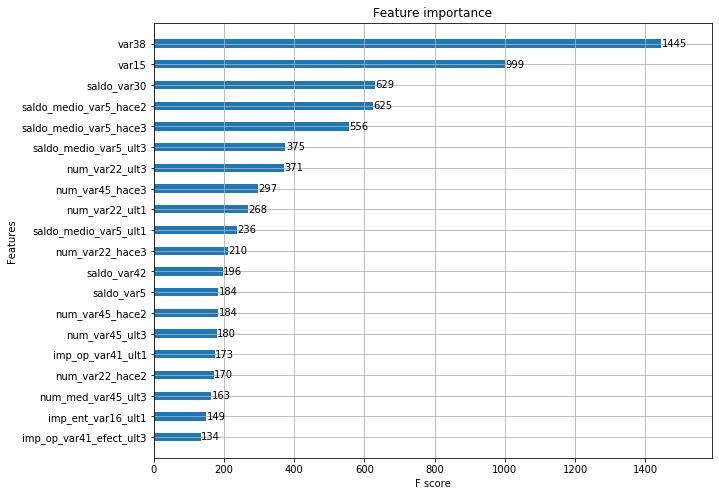

In [51]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [54]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score=roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC SCORE:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.141

[141]	valid_0's auc: 0.834265	valid_0's binary_logloss: 0.141328
[142]	valid_0's auc: 0.8342	valid_0's binary_logloss: 0.141359
Early stopping, best iteration is:
[42]	valid_0's auc: 0.839599	valid_0's binary_logloss: 0.139408
ROC SCORE:0.8396


In [56]:
from sklearn.model_selection import GridSearchCV

params={
    'num_leaves':[32, 64],
    'max_depth':[128, 160],
    'min_child_samples':[60, 100],
    'subsample':[0.8, 1]
}

grid_cv = GridSearchCV(lgbm_clf, param_grid=params)
grid_cv.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True )
print('최적의 파라미터:', grid_cv.best_params_)
lgbm_roc_score=roc_auc_score(y_test, grid_cv.predict_proba(X_test)[:, 1], average='macro')
print('ROC SCORE:{0:.4f}'.format(lgbm_roc_score))

C:\Users\SYeong\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.81613	valid_0's binary_logloss: 0.164998
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.15988
[3]	valid_0's auc: 0.827302	valid_0's binary_logloss: 0.156397
[4]	valid_0's auc: 0.8334	valid_0's binary_logloss: 0.153325
[5]	valid_0's auc: 0.836018	valid_0's binary_logloss: 0.150959
[6]	valid_0's auc: 0.838022	valid_0's binary_logloss: 0.149046
[7]	valid_0's auc: 0.837777	valid_0's binary_logloss: 0.147509
[8]	valid_0's auc: 0.839519	valid_0's binary_logloss: 0.146015
[9]	valid_0's auc: 0.840042	valid_0's binary_logloss: 0.145043
[10]	valid_0's auc: 0.839808	valid_0's binary_logloss: 0.144182
[11]	valid_0's auc: 0.83943	valid_0's binary_logloss: 0.14345
[12]	valid_0's auc: 0.838786	valid_0's binary_logloss: 0.142878
[13]	valid_0's auc: 0.838632	valid_0's binary_logloss: 0.142368
[14]	valid_0's auc: 0.838182	valid_0's binary_logloss: 0.14198
[15]	valid_0's auc: 0.838236	valid_0's binary_logloss: 0.1

[25]	valid_0's auc: 0.83912	valid_0's binary_logloss: 0.139815
[26]	valid_0's auc: 0.838779	valid_0's binary_logloss: 0.139741
[27]	valid_0's auc: 0.839241	valid_0's binary_logloss: 0.139648
[28]	valid_0's auc: 0.839378	valid_0's binary_logloss: 0.139578
[29]	valid_0's auc: 0.839436	valid_0's binary_logloss: 0.139581
[30]	valid_0's auc: 0.83907	valid_0's binary_logloss: 0.13958
[31]	valid_0's auc: 0.839226	valid_0's binary_logloss: 0.139539
[32]	valid_0's auc: 0.838983	valid_0's binary_logloss: 0.139561
[33]	valid_0's auc: 0.839235	valid_0's binary_logloss: 0.139528
[34]	valid_0's auc: 0.839004	valid_0's binary_logloss: 0.139567
[35]	valid_0's auc: 0.838946	valid_0's binary_logloss: 0.139572
[36]	valid_0's auc: 0.83898	valid_0's binary_logloss: 0.139554
[37]	valid_0's auc: 0.838888	valid_0's binary_logloss: 0.139557
[38]	valid_0's auc: 0.839133	valid_0's binary_logloss: 0.13952
[39]	valid_0's auc: 0.838929	valid_0's binary_logloss: 0.139584
[40]	valid_0's auc: 0.838869	valid_0's binary

[23]	valid_0's auc: 0.839768	valid_0's binary_logloss: 0.140027
[24]	valid_0's auc: 0.840299	valid_0's binary_logloss: 0.139904
[25]	valid_0's auc: 0.840676	valid_0's binary_logloss: 0.139735
[26]	valid_0's auc: 0.840242	valid_0's binary_logloss: 0.139708
[27]	valid_0's auc: 0.839924	valid_0's binary_logloss: 0.139651
[28]	valid_0's auc: 0.839647	valid_0's binary_logloss: 0.139574
[29]	valid_0's auc: 0.840154	valid_0's binary_logloss: 0.139481
[30]	valid_0's auc: 0.839602	valid_0's binary_logloss: 0.139497
[31]	valid_0's auc: 0.839072	valid_0's binary_logloss: 0.139568
[32]	valid_0's auc: 0.838748	valid_0's binary_logloss: 0.139579
[33]	valid_0's auc: 0.83895	valid_0's binary_logloss: 0.139492
[34]	valid_0's auc: 0.839078	valid_0's binary_logloss: 0.139459
[35]	valid_0's auc: 0.839413	valid_0's binary_logloss: 0.139362
[36]	valid_0's auc: 0.839157	valid_0's binary_logloss: 0.139395
[37]	valid_0's auc: 0.839051	valid_0's binary_logloss: 0.139443
[38]	valid_0's auc: 0.839482	valid_0's bi

[48]	valid_0's auc: 0.832243	valid_0's binary_logloss: 0.14031
[49]	valid_0's auc: 0.831921	valid_0's binary_logloss: 0.140405
[50]	valid_0's auc: 0.832069	valid_0's binary_logloss: 0.140407
[51]	valid_0's auc: 0.832407	valid_0's binary_logloss: 0.140363
[52]	valid_0's auc: 0.832199	valid_0's binary_logloss: 0.140428
[53]	valid_0's auc: 0.831934	valid_0's binary_logloss: 0.140486
[54]	valid_0's auc: 0.831687	valid_0's binary_logloss: 0.140539
[55]	valid_0's auc: 0.831704	valid_0's binary_logloss: 0.140548
[56]	valid_0's auc: 0.831534	valid_0's binary_logloss: 0.140619
[57]	valid_0's auc: 0.831559	valid_0's binary_logloss: 0.140603
[58]	valid_0's auc: 0.831638	valid_0's binary_logloss: 0.140617
[59]	valid_0's auc: 0.831472	valid_0's binary_logloss: 0.140672
[60]	valid_0's auc: 0.831635	valid_0's binary_logloss: 0.140654
[61]	valid_0's auc: 0.831468	valid_0's binary_logloss: 0.14067
[62]	valid_0's auc: 0.831422	valid_0's binary_logloss: 0.140692
[63]	valid_0's auc: 0.831476	valid_0's bin

[74]	valid_0's auc: 0.837861	valid_0's binary_logloss: 0.140019
[75]	valid_0's auc: 0.837849	valid_0's binary_logloss: 0.140033
[76]	valid_0's auc: 0.837686	valid_0's binary_logloss: 0.140096
[77]	valid_0's auc: 0.83772	valid_0's binary_logloss: 0.140106
[78]	valid_0's auc: 0.837974	valid_0's binary_logloss: 0.140097
[79]	valid_0's auc: 0.837823	valid_0's binary_logloss: 0.140155
[80]	valid_0's auc: 0.837692	valid_0's binary_logloss: 0.140243
[81]	valid_0's auc: 0.837772	valid_0's binary_logloss: 0.140229
[82]	valid_0's auc: 0.837727	valid_0's binary_logloss: 0.140259
[83]	valid_0's auc: 0.837665	valid_0's binary_logloss: 0.140294
[84]	valid_0's auc: 0.83759	valid_0's binary_logloss: 0.140326
[85]	valid_0's auc: 0.837548	valid_0's binary_logloss: 0.140336
[86]	valid_0's auc: 0.837472	valid_0's binary_logloss: 0.140391
[87]	valid_0's auc: 0.83735	valid_0's binary_logloss: 0.140403
[88]	valid_0's auc: 0.837305	valid_0's binary_logloss: 0.140416
[89]	valid_0's auc: 0.837366	valid_0's bina

[74]	valid_0's auc: 0.838822	valid_0's binary_logloss: 0.139693
[75]	valid_0's auc: 0.838799	valid_0's binary_logloss: 0.13972
[76]	valid_0's auc: 0.838771	valid_0's binary_logloss: 0.139744
[77]	valid_0's auc: 0.838798	valid_0's binary_logloss: 0.139776
[78]	valid_0's auc: 0.838938	valid_0's binary_logloss: 0.139781
[79]	valid_0's auc: 0.838508	valid_0's binary_logloss: 0.139861
[80]	valid_0's auc: 0.838438	valid_0's binary_logloss: 0.139898
[81]	valid_0's auc: 0.83852	valid_0's binary_logloss: 0.139903
[82]	valid_0's auc: 0.838358	valid_0's binary_logloss: 0.13995
[83]	valid_0's auc: 0.838124	valid_0's binary_logloss: 0.139988
[84]	valid_0's auc: 0.838149	valid_0's binary_logloss: 0.140006
[85]	valid_0's auc: 0.837856	valid_0's binary_logloss: 0.140101
[86]	valid_0's auc: 0.837729	valid_0's binary_logloss: 0.14015
[87]	valid_0's auc: 0.837937	valid_0's binary_logloss: 0.140065
[88]	valid_0's auc: 0.838024	valid_0's binary_logloss: 0.140121
[89]	valid_0's auc: 0.837928	valid_0's binar

[76]	valid_0's auc: 0.82626	valid_0's binary_logloss: 0.144186
[77]	valid_0's auc: 0.82612	valid_0's binary_logloss: 0.144257
[78]	valid_0's auc: 0.825729	valid_0's binary_logloss: 0.144359
[79]	valid_0's auc: 0.825478	valid_0's binary_logloss: 0.144508
[80]	valid_0's auc: 0.825498	valid_0's binary_logloss: 0.144554
[81]	valid_0's auc: 0.825024	valid_0's binary_logloss: 0.144747
[82]	valid_0's auc: 0.825132	valid_0's binary_logloss: 0.144772
[83]	valid_0's auc: 0.825026	valid_0's binary_logloss: 0.144824
[84]	valid_0's auc: 0.824951	valid_0's binary_logloss: 0.144925
[85]	valid_0's auc: 0.824768	valid_0's binary_logloss: 0.144988
[86]	valid_0's auc: 0.824758	valid_0's binary_logloss: 0.145056
[87]	valid_0's auc: 0.8248	valid_0's binary_logloss: 0.145129
[88]	valid_0's auc: 0.824653	valid_0's binary_logloss: 0.145213
[89]	valid_0's auc: 0.824807	valid_0's binary_logloss: 0.145189
[90]	valid_0's auc: 0.824252	valid_0's binary_logloss: 0.145344
[91]	valid_0's auc: 0.823852	valid_0's binar

[107]	valid_0's auc: 0.82786	valid_0's binary_logloss: 0.145009
[108]	valid_0's auc: 0.827549	valid_0's binary_logloss: 0.145143
[109]	valid_0's auc: 0.827392	valid_0's binary_logloss: 0.145258
[110]	valid_0's auc: 0.82711	valid_0's binary_logloss: 0.145324
[111]	valid_0's auc: 0.82697	valid_0's binary_logloss: 0.14544
[112]	valid_0's auc: 0.826975	valid_0's binary_logloss: 0.145445
[113]	valid_0's auc: 0.826809	valid_0's binary_logloss: 0.145537
[114]	valid_0's auc: 0.826901	valid_0's binary_logloss: 0.145594
[115]	valid_0's auc: 0.826739	valid_0's binary_logloss: 0.145694
Early stopping, best iteration is:
[15]	valid_0's auc: 0.837921	valid_0's binary_logloss: 0.141291
[1]	valid_0's auc: 0.81673	valid_0's binary_logloss: 0.164976
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822663	valid_0's binary_logloss: 0.159866
[3]	valid_0's auc: 0.829595	valid_0's binary_logloss: 0.156171
[4]	valid_0's auc: 0.831052	valid_0's binary_logloss: 0.153261
[5]	val

[14]	valid_0's auc: 0.833305	valid_0's binary_logloss: 0.14275
[15]	valid_0's auc: 0.832635	valid_0's binary_logloss: 0.14257
[16]	valid_0's auc: 0.832562	valid_0's binary_logloss: 0.142228
[17]	valid_0's auc: 0.832021	valid_0's binary_logloss: 0.142052
[18]	valid_0's auc: 0.831549	valid_0's binary_logloss: 0.141895
[19]	valid_0's auc: 0.831242	valid_0's binary_logloss: 0.141804
[20]	valid_0's auc: 0.83106	valid_0's binary_logloss: 0.141701
[21]	valid_0's auc: 0.830305	valid_0's binary_logloss: 0.14165
[22]	valid_0's auc: 0.830239	valid_0's binary_logloss: 0.141656
[23]	valid_0's auc: 0.830552	valid_0's binary_logloss: 0.141537
[24]	valid_0's auc: 0.830946	valid_0's binary_logloss: 0.141426
[25]	valid_0's auc: 0.829956	valid_0's binary_logloss: 0.141489
[26]	valid_0's auc: 0.829528	valid_0's binary_logloss: 0.141559
[27]	valid_0's auc: 0.829491	valid_0's binary_logloss: 0.141578
[28]	valid_0's auc: 0.829533	valid_0's binary_logloss: 0.141548
[29]	valid_0's auc: 0.829809	valid_0's binar

[48]	valid_0's auc: 0.836042	valid_0's binary_logloss: 0.14025
[49]	valid_0's auc: 0.836126	valid_0's binary_logloss: 0.140278
[50]	valid_0's auc: 0.835945	valid_0's binary_logloss: 0.140343
[51]	valid_0's auc: 0.836096	valid_0's binary_logloss: 0.140435
[52]	valid_0's auc: 0.835628	valid_0's binary_logloss: 0.140508
[53]	valid_0's auc: 0.8356	valid_0's binary_logloss: 0.140597
[54]	valid_0's auc: 0.835645	valid_0's binary_logloss: 0.140635
[55]	valid_0's auc: 0.834987	valid_0's binary_logloss: 0.140816
[56]	valid_0's auc: 0.834756	valid_0's binary_logloss: 0.140888
[57]	valid_0's auc: 0.834676	valid_0's binary_logloss: 0.140955
[58]	valid_0's auc: 0.834622	valid_0's binary_logloss: 0.140976
[59]	valid_0's auc: 0.834448	valid_0's binary_logloss: 0.141059
[60]	valid_0's auc: 0.834618	valid_0's binary_logloss: 0.141049
[61]	valid_0's auc: 0.834617	valid_0's binary_logloss: 0.141101
[62]	valid_0's auc: 0.834372	valid_0's binary_logloss: 0.1412
[63]	valid_0's auc: 0.834058	valid_0's binary

[69]	valid_0's auc: 0.833684	valid_0's binary_logloss: 0.14156
[70]	valid_0's auc: 0.833682	valid_0's binary_logloss: 0.141606
[71]	valid_0's auc: 0.833959	valid_0's binary_logloss: 0.141632
[72]	valid_0's auc: 0.833859	valid_0's binary_logloss: 0.141744
[73]	valid_0's auc: 0.833791	valid_0's binary_logloss: 0.141807
[74]	valid_0's auc: 0.833518	valid_0's binary_logloss: 0.141883
[75]	valid_0's auc: 0.833409	valid_0's binary_logloss: 0.141933
[76]	valid_0's auc: 0.833536	valid_0's binary_logloss: 0.141939
[77]	valid_0's auc: 0.83333	valid_0's binary_logloss: 0.142015
[78]	valid_0's auc: 0.833494	valid_0's binary_logloss: 0.142033
[79]	valid_0's auc: 0.833182	valid_0's binary_logloss: 0.142129
[80]	valid_0's auc: 0.83309	valid_0's binary_logloss: 0.142189
[81]	valid_0's auc: 0.833095	valid_0's binary_logloss: 0.142233
[82]	valid_0's auc: 0.833131	valid_0's binary_logloss: 0.142259
[83]	valid_0's auc: 0.833238	valid_0's binary_logloss: 0.142296
[84]	valid_0's auc: 0.833336	valid_0's bina

[95]	valid_0's auc: 0.831333	valid_0's binary_logloss: 0.141257
[96]	valid_0's auc: 0.831111	valid_0's binary_logloss: 0.141316
[97]	valid_0's auc: 0.831034	valid_0's binary_logloss: 0.141342
[98]	valid_0's auc: 0.830791	valid_0's binary_logloss: 0.141422
[99]	valid_0's auc: 0.83064	valid_0's binary_logloss: 0.141473
[100]	valid_0's auc: 0.83056	valid_0's binary_logloss: 0.141489
[101]	valid_0's auc: 0.830402	valid_0's binary_logloss: 0.141578
[102]	valid_0's auc: 0.830348	valid_0's binary_logloss: 0.141608
[103]	valid_0's auc: 0.830223	valid_0's binary_logloss: 0.141669
[104]	valid_0's auc: 0.830084	valid_0's binary_logloss: 0.141751
[105]	valid_0's auc: 0.830134	valid_0's binary_logloss: 0.141782
[106]	valid_0's auc: 0.8302	valid_0's binary_logloss: 0.141811
[107]	valid_0's auc: 0.830378	valid_0's binary_logloss: 0.141812
[108]	valid_0's auc: 0.830356	valid_0's binary_logloss: 0.141876
[109]	valid_0's auc: 0.830114	valid_0's binary_logloss: 0.141937
Early stopping, best iteration is:

[26]	valid_0's auc: 0.83866	valid_0's binary_logloss: 0.139795
[27]	valid_0's auc: 0.838474	valid_0's binary_logloss: 0.13973
[28]	valid_0's auc: 0.838418	valid_0's binary_logloss: 0.139661
[29]	valid_0's auc: 0.838527	valid_0's binary_logloss: 0.139586
[30]	valid_0's auc: 0.838578	valid_0's binary_logloss: 0.139533
[31]	valid_0's auc: 0.839062	valid_0's binary_logloss: 0.139431
[32]	valid_0's auc: 0.839243	valid_0's binary_logloss: 0.139362
[33]	valid_0's auc: 0.839482	valid_0's binary_logloss: 0.139288
[34]	valid_0's auc: 0.839612	valid_0's binary_logloss: 0.139266
[35]	valid_0's auc: 0.839746	valid_0's binary_logloss: 0.139241
[36]	valid_0's auc: 0.840074	valid_0's binary_logloss: 0.139138
[37]	valid_0's auc: 0.840105	valid_0's binary_logloss: 0.139101
[38]	valid_0's auc: 0.839838	valid_0's binary_logloss: 0.139141
[39]	valid_0's auc: 0.84006	valid_0's binary_logloss: 0.139095
[40]	valid_0's auc: 0.839944	valid_0's binary_logloss: 0.139144
[41]	valid_0's auc: 0.839925	valid_0's bina

[22]	valid_0's auc: 0.833837	valid_0's binary_logloss: 0.140571
[23]	valid_0's auc: 0.833222	valid_0's binary_logloss: 0.140512
[24]	valid_0's auc: 0.832726	valid_0's binary_logloss: 0.140541
[25]	valid_0's auc: 0.832998	valid_0's binary_logloss: 0.140458
[26]	valid_0's auc: 0.833056	valid_0's binary_logloss: 0.140424
[27]	valid_0's auc: 0.832427	valid_0's binary_logloss: 0.140421
[28]	valid_0's auc: 0.833075	valid_0's binary_logloss: 0.14028
[29]	valid_0's auc: 0.833494	valid_0's binary_logloss: 0.140215
[30]	valid_0's auc: 0.83327	valid_0's binary_logloss: 0.140214
[31]	valid_0's auc: 0.833041	valid_0's binary_logloss: 0.140216
[32]	valid_0's auc: 0.833344	valid_0's binary_logloss: 0.140148
[33]	valid_0's auc: 0.833307	valid_0's binary_logloss: 0.140091
[34]	valid_0's auc: 0.833239	valid_0's binary_logloss: 0.140069
[35]	valid_0's auc: 0.833202	valid_0's binary_logloss: 0.140067
[36]	valid_0's auc: 0.833345	valid_0's binary_logloss: 0.140029
[37]	valid_0's auc: 0.833447	valid_0's bin

[48]	valid_0's auc: 0.839077	valid_0's binary_logloss: 0.139096
[49]	valid_0's auc: 0.839174	valid_0's binary_logloss: 0.139078
[50]	valid_0's auc: 0.838956	valid_0's binary_logloss: 0.139158
[51]	valid_0's auc: 0.838835	valid_0's binary_logloss: 0.139179
[52]	valid_0's auc: 0.838791	valid_0's binary_logloss: 0.139196
[53]	valid_0's auc: 0.838768	valid_0's binary_logloss: 0.139185
[54]	valid_0's auc: 0.838734	valid_0's binary_logloss: 0.13921
[55]	valid_0's auc: 0.839211	valid_0's binary_logloss: 0.139085
[56]	valid_0's auc: 0.839273	valid_0's binary_logloss: 0.139116
[57]	valid_0's auc: 0.839275	valid_0's binary_logloss: 0.139122
[58]	valid_0's auc: 0.839241	valid_0's binary_logloss: 0.139178
[59]	valid_0's auc: 0.838947	valid_0's binary_logloss: 0.139258
[60]	valid_0's auc: 0.838987	valid_0's binary_logloss: 0.139261
[61]	valid_0's auc: 0.838546	valid_0's binary_logloss: 0.139374
[62]	valid_0's auc: 0.838383	valid_0's binary_logloss: 0.139407
[63]	valid_0's auc: 0.838042	valid_0's bi

[70]	valid_0's auc: 0.83981	valid_0's binary_logloss: 0.139598
[71]	valid_0's auc: 0.839869	valid_0's binary_logloss: 0.139594
[72]	valid_0's auc: 0.839788	valid_0's binary_logloss: 0.139654
[73]	valid_0's auc: 0.840147	valid_0's binary_logloss: 0.139624
[74]	valid_0's auc: 0.840137	valid_0's binary_logloss: 0.139665
[75]	valid_0's auc: 0.840289	valid_0's binary_logloss: 0.139644
[76]	valid_0's auc: 0.83992	valid_0's binary_logloss: 0.139749
[77]	valid_0's auc: 0.839998	valid_0's binary_logloss: 0.139765
[78]	valid_0's auc: 0.839997	valid_0's binary_logloss: 0.139773
[79]	valid_0's auc: 0.839839	valid_0's binary_logloss: 0.139823
[80]	valid_0's auc: 0.839758	valid_0's binary_logloss: 0.139909
[81]	valid_0's auc: 0.839724	valid_0's binary_logloss: 0.139927
[82]	valid_0's auc: 0.839696	valid_0's binary_logloss: 0.139925
[83]	valid_0's auc: 0.839667	valid_0's binary_logloss: 0.139955
[84]	valid_0's auc: 0.839997	valid_0's binary_logloss: 0.139924
[85]	valid_0's auc: 0.840045	valid_0's bin

[52]	valid_0's auc: 0.828667	valid_0's binary_logloss: 0.141662
[53]	valid_0's auc: 0.828375	valid_0's binary_logloss: 0.141759
[54]	valid_0's auc: 0.828289	valid_0's binary_logloss: 0.14185
[55]	valid_0's auc: 0.828094	valid_0's binary_logloss: 0.141913
[56]	valid_0's auc: 0.827873	valid_0's binary_logloss: 0.142028
[57]	valid_0's auc: 0.827762	valid_0's binary_logloss: 0.142073
[58]	valid_0's auc: 0.82781	valid_0's binary_logloss: 0.142083
[59]	valid_0's auc: 0.827926	valid_0's binary_logloss: 0.142165
[60]	valid_0's auc: 0.827877	valid_0's binary_logloss: 0.142248
[61]	valid_0's auc: 0.828077	valid_0's binary_logloss: 0.142244
[62]	valid_0's auc: 0.828247	valid_0's binary_logloss: 0.142296
[63]	valid_0's auc: 0.828207	valid_0's binary_logloss: 0.142347
[64]	valid_0's auc: 0.82836	valid_0's binary_logloss: 0.142381
[65]	valid_0's auc: 0.828464	valid_0's binary_logloss: 0.142403
[66]	valid_0's auc: 0.828148	valid_0's binary_logloss: 0.142508
[67]	valid_0's auc: 0.827903	valid_0's bina

[71]	valid_0's auc: 0.833368	valid_0's binary_logloss: 0.14151
[72]	valid_0's auc: 0.83317	valid_0's binary_logloss: 0.141617
[73]	valid_0's auc: 0.833047	valid_0's binary_logloss: 0.141702
[74]	valid_0's auc: 0.832752	valid_0's binary_logloss: 0.141814
[75]	valid_0's auc: 0.832448	valid_0's binary_logloss: 0.141904
[76]	valid_0's auc: 0.83222	valid_0's binary_logloss: 0.142
[77]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.14203
[78]	valid_0's auc: 0.832036	valid_0's binary_logloss: 0.142124
[79]	valid_0's auc: 0.831584	valid_0's binary_logloss: 0.142271
[80]	valid_0's auc: 0.831084	valid_0's binary_logloss: 0.142439
[81]	valid_0's auc: 0.830883	valid_0's binary_logloss: 0.142505
[82]	valid_0's auc: 0.830789	valid_0's binary_logloss: 0.142554
[83]	valid_0's auc: 0.830461	valid_0's binary_logloss: 0.142682
[84]	valid_0's auc: 0.830075	valid_0's binary_logloss: 0.142829
[85]	valid_0's auc: 0.830207	valid_0's binary_logloss: 0.14285
[86]	valid_0's auc: 0.829923	valid_0's binary_lo

[87]	valid_0's auc: 0.83314	valid_0's binary_logloss: 0.142556
[88]	valid_0's auc: 0.832907	valid_0's binary_logloss: 0.142699
[89]	valid_0's auc: 0.832782	valid_0's binary_logloss: 0.142761
[90]	valid_0's auc: 0.832641	valid_0's binary_logloss: 0.142856
[91]	valid_0's auc: 0.832797	valid_0's binary_logloss: 0.142878
[92]	valid_0's auc: 0.832635	valid_0's binary_logloss: 0.14297
[93]	valid_0's auc: 0.832507	valid_0's binary_logloss: 0.143047
[94]	valid_0's auc: 0.832463	valid_0's binary_logloss: 0.143088
[95]	valid_0's auc: 0.832325	valid_0's binary_logloss: 0.143165
[96]	valid_0's auc: 0.832065	valid_0's binary_logloss: 0.143245
[97]	valid_0's auc: 0.832049	valid_0's binary_logloss: 0.143347
[98]	valid_0's auc: 0.831908	valid_0's binary_logloss: 0.143444
[99]	valid_0's auc: 0.831953	valid_0's binary_logloss: 0.143483
[100]	valid_0's auc: 0.831728	valid_0's binary_logloss: 0.143626
[101]	valid_0's auc: 0.831734	valid_0's binary_logloss: 0.143612
[102]	valid_0's auc: 0.831391	valid_0's 

[102]	valid_0's auc: 0.822168	valid_0's binary_logloss: 0.146271
[103]	valid_0's auc: 0.821951	valid_0's binary_logloss: 0.146391
[104]	valid_0's auc: 0.821964	valid_0's binary_logloss: 0.146479
[105]	valid_0's auc: 0.821893	valid_0's binary_logloss: 0.146594
[106]	valid_0's auc: 0.821663	valid_0's binary_logloss: 0.146696
[107]	valid_0's auc: 0.821604	valid_0's binary_logloss: 0.146766
[108]	valid_0's auc: 0.821347	valid_0's binary_logloss: 0.146874
[109]	valid_0's auc: 0.821487	valid_0's binary_logloss: 0.146882
[110]	valid_0's auc: 0.821615	valid_0's binary_logloss: 0.146896
[111]	valid_0's auc: 0.821369	valid_0's binary_logloss: 0.147055
[112]	valid_0's auc: 0.821058	valid_0's binary_logloss: 0.14718
Early stopping, best iteration is:
[12]	valid_0's auc: 0.835592	valid_0's binary_logloss: 0.143404
[1]	valid_0's auc: 0.817465	valid_0's binary_logloss: 0.164895
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.828176	valid_0's binary_logloss: 0.159411

[1]	valid_0's auc: 0.822971	valid_0's binary_logloss: 0.165101
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.828728	valid_0's binary_logloss: 0.159785
[3]	valid_0's auc: 0.830832	valid_0's binary_logloss: 0.156017
[4]	valid_0's auc: 0.83154	valid_0's binary_logloss: 0.15319
[5]	valid_0's auc: 0.833818	valid_0's binary_logloss: 0.150761
[6]	valid_0's auc: 0.834224	valid_0's binary_logloss: 0.148815
[7]	valid_0's auc: 0.835329	valid_0's binary_logloss: 0.147338
[8]	valid_0's auc: 0.836144	valid_0's binary_logloss: 0.146094
[9]	valid_0's auc: 0.835613	valid_0's binary_logloss: 0.145179
[10]	valid_0's auc: 0.836519	valid_0's binary_logloss: 0.144304
[11]	valid_0's auc: 0.836728	valid_0's binary_logloss: 0.143576
[12]	valid_0's auc: 0.837121	valid_0's binary_logloss: 0.142892
[13]	valid_0's auc: 0.837902	valid_0's binary_logloss: 0.142287
[14]	valid_0's auc: 0.838274	valid_0's binary_logloss: 0.141902
[15]	valid_0's auc: 0.83767	valid_0's binary_logloss:

[24]	valid_0's auc: 0.835199	valid_0's binary_logloss: 0.140328
[25]	valid_0's auc: 0.83457	valid_0's binary_logloss: 0.140301
[26]	valid_0's auc: 0.834087	valid_0's binary_logloss: 0.140349
[27]	valid_0's auc: 0.833822	valid_0's binary_logloss: 0.140277
[28]	valid_0's auc: 0.833886	valid_0's binary_logloss: 0.140255
[29]	valid_0's auc: 0.833937	valid_0's binary_logloss: 0.140189
[30]	valid_0's auc: 0.834461	valid_0's binary_logloss: 0.140113
[31]	valid_0's auc: 0.83444	valid_0's binary_logloss: 0.140064
[32]	valid_0's auc: 0.834196	valid_0's binary_logloss: 0.140095
[33]	valid_0's auc: 0.834143	valid_0's binary_logloss: 0.140029
[34]	valid_0's auc: 0.833865	valid_0's binary_logloss: 0.140055
[35]	valid_0's auc: 0.833699	valid_0's binary_logloss: 0.140082
[36]	valid_0's auc: 0.833221	valid_0's binary_logloss: 0.140158
[37]	valid_0's auc: 0.832792	valid_0's binary_logloss: 0.14018
[38]	valid_0's auc: 0.832977	valid_0's binary_logloss: 0.140154
[39]	valid_0's auc: 0.832913	valid_0's bina

[49]	valid_0's auc: 0.83827	valid_0's binary_logloss: 0.13968
[50]	valid_0's auc: 0.838029	valid_0's binary_logloss: 0.139727
[51]	valid_0's auc: 0.838077	valid_0's binary_logloss: 0.13975
[52]	valid_0's auc: 0.838081	valid_0's binary_logloss: 0.139779
[53]	valid_0's auc: 0.838632	valid_0's binary_logloss: 0.139643
[54]	valid_0's auc: 0.838634	valid_0's binary_logloss: 0.139662
[55]	valid_0's auc: 0.838551	valid_0's binary_logloss: 0.139692
[56]	valid_0's auc: 0.838303	valid_0's binary_logloss: 0.139748
[57]	valid_0's auc: 0.838445	valid_0's binary_logloss: 0.139719
[58]	valid_0's auc: 0.838262	valid_0's binary_logloss: 0.139754
[59]	valid_0's auc: 0.837652	valid_0's binary_logloss: 0.139829
[60]	valid_0's auc: 0.837642	valid_0's binary_logloss: 0.13984
[61]	valid_0's auc: 0.837677	valid_0's binary_logloss: 0.139833
[62]	valid_0's auc: 0.837896	valid_0's binary_logloss: 0.139818
[63]	valid_0's auc: 0.837949	valid_0's binary_logloss: 0.139811
[64]	valid_0's auc: 0.83776	valid_0's binary

[67]	valid_0's auc: 0.839402	valid_0's binary_logloss: 0.139549
[68]	valid_0's auc: 0.839217	valid_0's binary_logloss: 0.139572
[69]	valid_0's auc: 0.839346	valid_0's binary_logloss: 0.139568
[70]	valid_0's auc: 0.839369	valid_0's binary_logloss: 0.139579
[71]	valid_0's auc: 0.839299	valid_0's binary_logloss: 0.13959
[72]	valid_0's auc: 0.839153	valid_0's binary_logloss: 0.139624
[73]	valid_0's auc: 0.839046	valid_0's binary_logloss: 0.13966
[74]	valid_0's auc: 0.838822	valid_0's binary_logloss: 0.139693
[75]	valid_0's auc: 0.838799	valid_0's binary_logloss: 0.13972
[76]	valid_0's auc: 0.838771	valid_0's binary_logloss: 0.139744
[77]	valid_0's auc: 0.838798	valid_0's binary_logloss: 0.139776
[78]	valid_0's auc: 0.838938	valid_0's binary_logloss: 0.139781
[79]	valid_0's auc: 0.838508	valid_0's binary_logloss: 0.139861
[80]	valid_0's auc: 0.838438	valid_0's binary_logloss: 0.139898
[81]	valid_0's auc: 0.83852	valid_0's binary_logloss: 0.139903
[82]	valid_0's auc: 0.838358	valid_0's binar

[74]	valid_0's auc: 0.830118	valid_0's binary_logloss: 0.141282
[75]	valid_0's auc: 0.830196	valid_0's binary_logloss: 0.141247
[76]	valid_0's auc: 0.830296	valid_0's binary_logloss: 0.141246
[77]	valid_0's auc: 0.830332	valid_0's binary_logloss: 0.141201
[78]	valid_0's auc: 0.830533	valid_0's binary_logloss: 0.141196
[79]	valid_0's auc: 0.830793	valid_0's binary_logloss: 0.141141
[80]	valid_0's auc: 0.83047	valid_0's binary_logloss: 0.14119
[81]	valid_0's auc: 0.830533	valid_0's binary_logloss: 0.141207
[82]	valid_0's auc: 0.830541	valid_0's binary_logloss: 0.141211
[83]	valid_0's auc: 0.83063	valid_0's binary_logloss: 0.141193
[84]	valid_0's auc: 0.830698	valid_0's binary_logloss: 0.14117
[85]	valid_0's auc: 0.830958	valid_0's binary_logloss: 0.141156
[86]	valid_0's auc: 0.830792	valid_0's binary_logloss: 0.141225
[87]	valid_0's auc: 0.83092	valid_0's binary_logloss: 0.141236
[88]	valid_0's auc: 0.830827	valid_0's binary_logloss: 0.141299
[89]	valid_0's auc: 0.830541	valid_0's binary

[98]	valid_0's auc: 0.837233	valid_0's binary_logloss: 0.140556
[99]	valid_0's auc: 0.836663	valid_0's binary_logloss: 0.140704
[100]	valid_0's auc: 0.836637	valid_0's binary_logloss: 0.140738
[101]	valid_0's auc: 0.836511	valid_0's binary_logloss: 0.14079
[102]	valid_0's auc: 0.83613	valid_0's binary_logloss: 0.140916
[103]	valid_0's auc: 0.836058	valid_0's binary_logloss: 0.140968
[104]	valid_0's auc: 0.835918	valid_0's binary_logloss: 0.141011
[105]	valid_0's auc: 0.835796	valid_0's binary_logloss: 0.141047
[106]	valid_0's auc: 0.835551	valid_0's binary_logloss: 0.141112
[107]	valid_0's auc: 0.83542	valid_0's binary_logloss: 0.141149
[108]	valid_0's auc: 0.835716	valid_0's binary_logloss: 0.141125
[109]	valid_0's auc: 0.83539	valid_0's binary_logloss: 0.141218
[110]	valid_0's auc: 0.835209	valid_0's binary_logloss: 0.141291
[111]	valid_0's auc: 0.835065	valid_0's binary_logloss: 0.141348
[112]	valid_0's auc: 0.835161	valid_0's binary_logloss: 0.141333
[113]	valid_0's auc: 0.835189	v

[95]	valid_0's auc: 0.837876	valid_0's binary_logloss: 0.140219
[96]	valid_0's auc: 0.837826	valid_0's binary_logloss: 0.140255
[97]	valid_0's auc: 0.837885	valid_0's binary_logloss: 0.140255
[98]	valid_0's auc: 0.838038	valid_0's binary_logloss: 0.140239
[99]	valid_0's auc: 0.83797	valid_0's binary_logloss: 0.140253
[100]	valid_0's auc: 0.838032	valid_0's binary_logloss: 0.140281
[101]	valid_0's auc: 0.837981	valid_0's binary_logloss: 0.140295
[102]	valid_0's auc: 0.837911	valid_0's binary_logloss: 0.140332
[103]	valid_0's auc: 0.837645	valid_0's binary_logloss: 0.140407
[104]	valid_0's auc: 0.837614	valid_0's binary_logloss: 0.140419
[105]	valid_0's auc: 0.837514	valid_0's binary_logloss: 0.14045
[106]	valid_0's auc: 0.837547	valid_0's binary_logloss: 0.140481
[107]	valid_0's auc: 0.837511	valid_0's binary_logloss: 0.140525
[108]	valid_0's auc: 0.837165	valid_0's binary_logloss: 0.140637
[109]	valid_0's auc: 0.8371	valid_0's binary_logloss: 0.140669
[110]	valid_0's auc: 0.837134	vali

[1]	valid_0's auc: 0.817048	valid_0's binary_logloss: 0.165042
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.820838	valid_0's binary_logloss: 0.159671
[3]	valid_0's auc: 0.827828	valid_0's binary_logloss: 0.156036
[4]	valid_0's auc: 0.831388	valid_0's binary_logloss: 0.153065
[5]	valid_0's auc: 0.834493	valid_0's binary_logloss: 0.150758
[6]	valid_0's auc: 0.833775	valid_0's binary_logloss: 0.149055
[7]	valid_0's auc: 0.836672	valid_0's binary_logloss: 0.147391
[8]	valid_0's auc: 0.835878	valid_0's binary_logloss: 0.146178
[9]	valid_0's auc: 0.836038	valid_0's binary_logloss: 0.145107
[10]	valid_0's auc: 0.836429	valid_0's binary_logloss: 0.144153
[11]	valid_0's auc: 0.836388	valid_0's binary_logloss: 0.143351
[12]	valid_0's auc: 0.836122	valid_0's binary_logloss: 0.142803
[13]	valid_0's auc: 0.836547	valid_0's binary_logloss: 0.142243
[14]	valid_0's auc: 0.837837	valid_0's binary_logloss: 0.141718
[15]	valid_0's auc: 0.837921	valid_0's binary_loglo

[18]	valid_0's auc: 0.835872	valid_0's binary_logloss: 0.141256
[19]	valid_0's auc: 0.835242	valid_0's binary_logloss: 0.141186
[20]	valid_0's auc: 0.835731	valid_0's binary_logloss: 0.140946
[21]	valid_0's auc: 0.834984	valid_0's binary_logloss: 0.140914
[22]	valid_0's auc: 0.83655	valid_0's binary_logloss: 0.140596
[23]	valid_0's auc: 0.836903	valid_0's binary_logloss: 0.140423
[24]	valid_0's auc: 0.837346	valid_0's binary_logloss: 0.140282
[25]	valid_0's auc: 0.837461	valid_0's binary_logloss: 0.140158
[26]	valid_0's auc: 0.837303	valid_0's binary_logloss: 0.140169
[27]	valid_0's auc: 0.837557	valid_0's binary_logloss: 0.140113
[28]	valid_0's auc: 0.837108	valid_0's binary_logloss: 0.140154
[29]	valid_0's auc: 0.837503	valid_0's binary_logloss: 0.14008
[30]	valid_0's auc: 0.83748	valid_0's binary_logloss: 0.140051
[31]	valid_0's auc: 0.837533	valid_0's binary_logloss: 0.140006
[32]	valid_0's auc: 0.83708	valid_0's binary_logloss: 0.140054
[33]	valid_0's auc: 0.836874	valid_0's binar

[33]	valid_0's auc: 0.829851	valid_0's binary_logloss: 0.141488
[34]	valid_0's auc: 0.82916	valid_0's binary_logloss: 0.141607
[35]	valid_0's auc: 0.828503	valid_0's binary_logloss: 0.141781
[36]	valid_0's auc: 0.828875	valid_0's binary_logloss: 0.141779
[37]	valid_0's auc: 0.828688	valid_0's binary_logloss: 0.141825
[38]	valid_0's auc: 0.828805	valid_0's binary_logloss: 0.141889
[39]	valid_0's auc: 0.828364	valid_0's binary_logloss: 0.141968
[40]	valid_0's auc: 0.82867	valid_0's binary_logloss: 0.141922
[41]	valid_0's auc: 0.828438	valid_0's binary_logloss: 0.142026
[42]	valid_0's auc: 0.828362	valid_0's binary_logloss: 0.142075
[43]	valid_0's auc: 0.827927	valid_0's binary_logloss: 0.142169
[44]	valid_0's auc: 0.828071	valid_0's binary_logloss: 0.142226
[45]	valid_0's auc: 0.828571	valid_0's binary_logloss: 0.142187
[46]	valid_0's auc: 0.828711	valid_0's binary_logloss: 0.142181
[47]	valid_0's auc: 0.828757	valid_0's binary_logloss: 0.142214
[48]	valid_0's auc: 0.828464	valid_0's bin

[70]	valid_0's auc: 0.832966	valid_0's binary_logloss: 0.141873
[71]	valid_0's auc: 0.832793	valid_0's binary_logloss: 0.141952
[72]	valid_0's auc: 0.833059	valid_0's binary_logloss: 0.14193
[73]	valid_0's auc: 0.832872	valid_0's binary_logloss: 0.141997
[74]	valid_0's auc: 0.83287	valid_0's binary_logloss: 0.142062
[75]	valid_0's auc: 0.83308	valid_0's binary_logloss: 0.142059
[76]	valid_0's auc: 0.833377	valid_0's binary_logloss: 0.142047
[77]	valid_0's auc: 0.832937	valid_0's binary_logloss: 0.142192
[78]	valid_0's auc: 0.832632	valid_0's binary_logloss: 0.142331
[79]	valid_0's auc: 0.832541	valid_0's binary_logloss: 0.142444
[80]	valid_0's auc: 0.832176	valid_0's binary_logloss: 0.142588
[81]	valid_0's auc: 0.832288	valid_0's binary_logloss: 0.142606
[82]	valid_0's auc: 0.831845	valid_0's binary_logloss: 0.142778
[83]	valid_0's auc: 0.831731	valid_0's binary_logloss: 0.142828
[84]	valid_0's auc: 0.831726	valid_0's binary_logloss: 0.142885
[85]	valid_0's auc: 0.831663	valid_0's bina

[84]	valid_0's auc: 0.833336	valid_0's binary_logloss: 0.142322
[85]	valid_0's auc: 0.833403	valid_0's binary_logloss: 0.142324
[86]	valid_0's auc: 0.833294	valid_0's binary_logloss: 0.142395
[87]	valid_0's auc: 0.833083	valid_0's binary_logloss: 0.142514
[88]	valid_0's auc: 0.833025	valid_0's binary_logloss: 0.14257
[89]	valid_0's auc: 0.833266	valid_0's binary_logloss: 0.14255
[90]	valid_0's auc: 0.83309	valid_0's binary_logloss: 0.14264
[91]	valid_0's auc: 0.832893	valid_0's binary_logloss: 0.14274
[92]	valid_0's auc: 0.832823	valid_0's binary_logloss: 0.142813
[93]	valid_0's auc: 0.832884	valid_0's binary_logloss: 0.142839
[94]	valid_0's auc: 0.832934	valid_0's binary_logloss: 0.142827
[95]	valid_0's auc: 0.832911	valid_0's binary_logloss: 0.142891
[96]	valid_0's auc: 0.832705	valid_0's binary_logloss: 0.142992
[97]	valid_0's auc: 0.832614	valid_0's binary_logloss: 0.143102
[98]	valid_0's auc: 0.832319	valid_0's binary_logloss: 0.143221
[99]	valid_0's auc: 0.832494	valid_0's binary

[25]	valid_0's auc: 0.83898	valid_0's binary_logloss: 0.13986
[26]	valid_0's auc: 0.83866	valid_0's binary_logloss: 0.139795
[27]	valid_0's auc: 0.838474	valid_0's binary_logloss: 0.13973
[28]	valid_0's auc: 0.838418	valid_0's binary_logloss: 0.139661
[29]	valid_0's auc: 0.838527	valid_0's binary_logloss: 0.139586
[30]	valid_0's auc: 0.838578	valid_0's binary_logloss: 0.139533
[31]	valid_0's auc: 0.839062	valid_0's binary_logloss: 0.139431
[32]	valid_0's auc: 0.839243	valid_0's binary_logloss: 0.139362
[33]	valid_0's auc: 0.839482	valid_0's binary_logloss: 0.139288
[34]	valid_0's auc: 0.839612	valid_0's binary_logloss: 0.139266
[35]	valid_0's auc: 0.839746	valid_0's binary_logloss: 0.139241
[36]	valid_0's auc: 0.840074	valid_0's binary_logloss: 0.139138
[37]	valid_0's auc: 0.840105	valid_0's binary_logloss: 0.139101
[38]	valid_0's auc: 0.839838	valid_0's binary_logloss: 0.139141
[39]	valid_0's auc: 0.84006	valid_0's binary_logloss: 0.139095
[40]	valid_0's auc: 0.839944	valid_0's binary

[21]	valid_0's auc: 0.833804	valid_0's binary_logloss: 0.140723
[22]	valid_0's auc: 0.833837	valid_0's binary_logloss: 0.140571
[23]	valid_0's auc: 0.833222	valid_0's binary_logloss: 0.140512
[24]	valid_0's auc: 0.832726	valid_0's binary_logloss: 0.140541
[25]	valid_0's auc: 0.832998	valid_0's binary_logloss: 0.140458
[26]	valid_0's auc: 0.833056	valid_0's binary_logloss: 0.140424
[27]	valid_0's auc: 0.832427	valid_0's binary_logloss: 0.140421
[28]	valid_0's auc: 0.833075	valid_0's binary_logloss: 0.14028
[29]	valid_0's auc: 0.833494	valid_0's binary_logloss: 0.140215
[30]	valid_0's auc: 0.83327	valid_0's binary_logloss: 0.140214
[31]	valid_0's auc: 0.833041	valid_0's binary_logloss: 0.140216
[32]	valid_0's auc: 0.833344	valid_0's binary_logloss: 0.140148
[33]	valid_0's auc: 0.833307	valid_0's binary_logloss: 0.140091
[34]	valid_0's auc: 0.833239	valid_0's binary_logloss: 0.140069
[35]	valid_0's auc: 0.833202	valid_0's binary_logloss: 0.140067
[36]	valid_0's auc: 0.833345	valid_0's bin

[47]	valid_0's auc: 0.839121	valid_0's binary_logloss: 0.139088
[48]	valid_0's auc: 0.839077	valid_0's binary_logloss: 0.139096
[49]	valid_0's auc: 0.839174	valid_0's binary_logloss: 0.139078
[50]	valid_0's auc: 0.838956	valid_0's binary_logloss: 0.139158
[51]	valid_0's auc: 0.838835	valid_0's binary_logloss: 0.139179
[52]	valid_0's auc: 0.838791	valid_0's binary_logloss: 0.139196
[53]	valid_0's auc: 0.838768	valid_0's binary_logloss: 0.139185
[54]	valid_0's auc: 0.838734	valid_0's binary_logloss: 0.13921
[55]	valid_0's auc: 0.839211	valid_0's binary_logloss: 0.139085
[56]	valid_0's auc: 0.839273	valid_0's binary_logloss: 0.139116
[57]	valid_0's auc: 0.839275	valid_0's binary_logloss: 0.139122
[58]	valid_0's auc: 0.839241	valid_0's binary_logloss: 0.139178
[59]	valid_0's auc: 0.838947	valid_0's binary_logloss: 0.139258
[60]	valid_0's auc: 0.838987	valid_0's binary_logloss: 0.139261
[61]	valid_0's auc: 0.838546	valid_0's binary_logloss: 0.139374
[62]	valid_0's auc: 0.838383	valid_0's bi

[70]	valid_0's auc: 0.83981	valid_0's binary_logloss: 0.139598
[71]	valid_0's auc: 0.839869	valid_0's binary_logloss: 0.139594
[72]	valid_0's auc: 0.839788	valid_0's binary_logloss: 0.139654
[73]	valid_0's auc: 0.840147	valid_0's binary_logloss: 0.139624
[74]	valid_0's auc: 0.840137	valid_0's binary_logloss: 0.139665
[75]	valid_0's auc: 0.840289	valid_0's binary_logloss: 0.139644
[76]	valid_0's auc: 0.83992	valid_0's binary_logloss: 0.139749
[77]	valid_0's auc: 0.839998	valid_0's binary_logloss: 0.139765
[78]	valid_0's auc: 0.839997	valid_0's binary_logloss: 0.139773
[79]	valid_0's auc: 0.839839	valid_0's binary_logloss: 0.139823
[80]	valid_0's auc: 0.839758	valid_0's binary_logloss: 0.139909
[81]	valid_0's auc: 0.839724	valid_0's binary_logloss: 0.139927
[82]	valid_0's auc: 0.839696	valid_0's binary_logloss: 0.139925
[83]	valid_0's auc: 0.839667	valid_0's binary_logloss: 0.139955
[84]	valid_0's auc: 0.839997	valid_0's binary_logloss: 0.139924
[85]	valid_0's auc: 0.840045	valid_0's bin

[52]	valid_0's auc: 0.828667	valid_0's binary_logloss: 0.141662
[53]	valid_0's auc: 0.828375	valid_0's binary_logloss: 0.141759
[54]	valid_0's auc: 0.828289	valid_0's binary_logloss: 0.14185
[55]	valid_0's auc: 0.828094	valid_0's binary_logloss: 0.141913
[56]	valid_0's auc: 0.827873	valid_0's binary_logloss: 0.142028
[57]	valid_0's auc: 0.827762	valid_0's binary_logloss: 0.142073
[58]	valid_0's auc: 0.82781	valid_0's binary_logloss: 0.142083
[59]	valid_0's auc: 0.827926	valid_0's binary_logloss: 0.142165
[60]	valid_0's auc: 0.827877	valid_0's binary_logloss: 0.142248
[61]	valid_0's auc: 0.828077	valid_0's binary_logloss: 0.142244
[62]	valid_0's auc: 0.828247	valid_0's binary_logloss: 0.142296
[63]	valid_0's auc: 0.828207	valid_0's binary_logloss: 0.142347
[64]	valid_0's auc: 0.82836	valid_0's binary_logloss: 0.142381
[65]	valid_0's auc: 0.828464	valid_0's binary_logloss: 0.142403
[66]	valid_0's auc: 0.828148	valid_0's binary_logloss: 0.142508
[67]	valid_0's auc: 0.827903	valid_0's bina

[76]	valid_0's auc: 0.83222	valid_0's binary_logloss: 0.142
[77]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.14203
[78]	valid_0's auc: 0.832036	valid_0's binary_logloss: 0.142124
[79]	valid_0's auc: 0.831584	valid_0's binary_logloss: 0.142271
[80]	valid_0's auc: 0.831084	valid_0's binary_logloss: 0.142439
[81]	valid_0's auc: 0.830883	valid_0's binary_logloss: 0.142505
[82]	valid_0's auc: 0.830789	valid_0's binary_logloss: 0.142554
[83]	valid_0's auc: 0.830461	valid_0's binary_logloss: 0.142682
[84]	valid_0's auc: 0.830075	valid_0's binary_logloss: 0.142829
[85]	valid_0's auc: 0.830207	valid_0's binary_logloss: 0.14285
[86]	valid_0's auc: 0.829923	valid_0's binary_logloss: 0.142907
[87]	valid_0's auc: 0.829884	valid_0's binary_logloss: 0.142993
[88]	valid_0's auc: 0.829552	valid_0's binary_logloss: 0.143083
[89]	valid_0's auc: 0.829472	valid_0's binary_logloss: 0.143174
[90]	valid_0's auc: 0.829466	valid_0's binary_logloss: 0.143253
[91]	valid_0's auc: 0.829388	valid_0's binary_

[88]	valid_0's auc: 0.832907	valid_0's binary_logloss: 0.142699
[89]	valid_0's auc: 0.832782	valid_0's binary_logloss: 0.142761
[90]	valid_0's auc: 0.832641	valid_0's binary_logloss: 0.142856
[91]	valid_0's auc: 0.832797	valid_0's binary_logloss: 0.142878
[92]	valid_0's auc: 0.832635	valid_0's binary_logloss: 0.14297
[93]	valid_0's auc: 0.832507	valid_0's binary_logloss: 0.143047
[94]	valid_0's auc: 0.832463	valid_0's binary_logloss: 0.143088
[95]	valid_0's auc: 0.832325	valid_0's binary_logloss: 0.143165
[96]	valid_0's auc: 0.832065	valid_0's binary_logloss: 0.143245
[97]	valid_0's auc: 0.832049	valid_0's binary_logloss: 0.143347
[98]	valid_0's auc: 0.831908	valid_0's binary_logloss: 0.143444
[99]	valid_0's auc: 0.831953	valid_0's binary_logloss: 0.143483
[100]	valid_0's auc: 0.831728	valid_0's binary_logloss: 0.143626
[101]	valid_0's auc: 0.831734	valid_0's binary_logloss: 0.143612
[102]	valid_0's auc: 0.831391	valid_0's binary_logloss: 0.143783
[103]	valid_0's auc: 0.831214	valid_0'

[103]	valid_0's auc: 0.821951	valid_0's binary_logloss: 0.146391
[104]	valid_0's auc: 0.821964	valid_0's binary_logloss: 0.146479
[105]	valid_0's auc: 0.821893	valid_0's binary_logloss: 0.146594
[106]	valid_0's auc: 0.821663	valid_0's binary_logloss: 0.146696
[107]	valid_0's auc: 0.821604	valid_0's binary_logloss: 0.146766
[108]	valid_0's auc: 0.821347	valid_0's binary_logloss: 0.146874
[109]	valid_0's auc: 0.821487	valid_0's binary_logloss: 0.146882
[110]	valid_0's auc: 0.821615	valid_0's binary_logloss: 0.146896
[111]	valid_0's auc: 0.821369	valid_0's binary_logloss: 0.147055
[112]	valid_0's auc: 0.821058	valid_0's binary_logloss: 0.14718
Early stopping, best iteration is:
[12]	valid_0's auc: 0.835592	valid_0's binary_logloss: 0.143404
[1]	valid_0's auc: 0.817465	valid_0's binary_logloss: 0.164895
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.828176	valid_0's binary_logloss: 0.159411
[3]	valid_0's auc: 0.832597	valid_0's binary_logloss: 0.155736
[

[1]	valid_0's auc: 0.822971	valid_0's binary_logloss: 0.165101
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.828728	valid_0's binary_logloss: 0.159785
[3]	valid_0's auc: 0.830832	valid_0's binary_logloss: 0.156017
[4]	valid_0's auc: 0.83154	valid_0's binary_logloss: 0.15319
[5]	valid_0's auc: 0.833818	valid_0's binary_logloss: 0.150761
[6]	valid_0's auc: 0.834224	valid_0's binary_logloss: 0.148815
[7]	valid_0's auc: 0.835329	valid_0's binary_logloss: 0.147338
[8]	valid_0's auc: 0.836144	valid_0's binary_logloss: 0.146094
[9]	valid_0's auc: 0.835613	valid_0's binary_logloss: 0.145179
[10]	valid_0's auc: 0.836519	valid_0's binary_logloss: 0.144304
[11]	valid_0's auc: 0.836728	valid_0's binary_logloss: 0.143576
[12]	valid_0's auc: 0.837121	valid_0's binary_logloss: 0.142892
[13]	valid_0's auc: 0.837902	valid_0's binary_logloss: 0.142287
[14]	valid_0's auc: 0.838274	valid_0's binary_logloss: 0.141902
[15]	valid_0's auc: 0.83767	valid_0's binary_logloss:

[18]	valid_0's auc: 0.843853	valid_0's binary_logloss: 0.140054
[19]	valid_0's auc: 0.844012	valid_0's binary_logloss: 0.139782
[20]	valid_0's auc: 0.843654	valid_0's binary_logloss: 0.139614
[21]	valid_0's auc: 0.843765	valid_0's binary_logloss: 0.139406
[22]	valid_0's auc: 0.844171	valid_0's binary_logloss: 0.139253
[23]	valid_0's auc: 0.843901	valid_0's binary_logloss: 0.139093
[24]	valid_0's auc: 0.843814	valid_0's binary_logloss: 0.139015
[25]	valid_0's auc: 0.843672	valid_0's binary_logloss: 0.138915
[26]	valid_0's auc: 0.843894	valid_0's binary_logloss: 0.138828
[27]	valid_0's auc: 0.843845	valid_0's binary_logloss: 0.138723
[28]	valid_0's auc: 0.843817	valid_0's binary_logloss: 0.138681
[29]	valid_0's auc: 0.844032	valid_0's binary_logloss: 0.13859
[30]	valid_0's auc: 0.844089	valid_0's binary_logloss: 0.138538
[31]	valid_0's auc: 0.844137	valid_0's binary_logloss: 0.138484
[32]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.138591
[33]	valid_0's auc: 0.842676	valid_0's bi

In [60]:
lgbm_clf = LGBMClassifier(n_estimators=1000, max_depth=128, min_child_samples=100, num_leaves=32, subsample=0.8)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC SCORE:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss: